In [152]:
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import yfinance as yf
import mplfinance as mpf
import requests
import plotly.graph_objects as go
import talib

In [153]:
def get_tsla_recent_data():
    session = requests.Session()
    session.headers.update({'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'})
    tsla = yf.Ticker('TSLA')
    df = tsla.history(period='4mo', interval='4h')
    return df

def visualize(df, title="TSLA Candlestick Chart"):
    """
    Plots a candlestick chart using mplfinance for the given DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame containing OHLC data.
    title (str): The title of the chart.
    """
    # Ensure the DataFrame index is a datetime index
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Plot the candlestick chart
    mpf.plot(df, type='candle', style='charles', title=title, ylabel="Price",
             volume=True, figsize=(10, 5))

def visualize_interactive(df, title="TSLA Candlestick Chart"):
    fig = go.Figure()
    
    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index,
        open=df['Open'],
        high=df['High'],
        low=df['Low'],
        close=df['Close'],
        name='TSLA'
    ))
    
    # Add SMA 50 line
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['SMA_short'],
        mode='lines',
        name='SMA Short',
        line=dict(color='blue', width=2)
    ))
    
    # Add SMA 200 line
    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['SMA_long'],
        mode='lines',
        name='SMA Long',
        line=dict(color='orange', width=2)
    ))
    
    fig.update_layout(title=title, xaxis_rangeslider_visible=False)
    fig.show()

def generate_ma_crossover_signals(df, short_ma_col='SMA_short', long_ma_col='SMA_long'):    
    df = df.copy()
    
    # Initialize signal column
    df['Signal'] = 0
    
    # Generate crossover signals
    # Buy signal: Short MA crosses above Long MA (Golden Cross)
    df['Signal'] = np.where(
        (df[short_ma_col] > df[long_ma_col]) & 
        (df[short_ma_col].shift(1) <= df[long_ma_col].shift(1)), 
        1, df['Signal']
    )
    
    # Sell signal: Short MA crosses below Long MA (Death Cross)
    df['Signal'] = np.where(
        (df[short_ma_col] < df[long_ma_col]) & 
        (df[short_ma_col].shift(1) >= df[long_ma_col].shift(1)), 
        -1, df['Signal']
    )
        
    # Add signal markers for plotting
    df['Buy_Signal'] = np.where(df['Signal'] == 1, df['Close'], np.nan)
    df['Sell_Signal'] = np.where(df['Signal'] == -1, df['Close'], np.nan)
    
    return df

def visualize_interactive_with_signals(df, title="TSLA with MA Crossover Signals"):
    fig = go.Figure()
    
    # Candlestick chart
    fig.add_trace(go.Candlestick(
        x=df.index, open=df['Open'], high=df['High'], 
        low=df['Low'], close=df['Close'], name='TSLA'
    ))
    
    # Moving averages
    fig.add_trace(go.Scatter(x=df.index, y=df['SMA_short'], mode='lines', 
                            name='SMA Short', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=df.index, y=df['SMA_long'], mode='lines', 
                            name='SMA Long', line=dict(color='red', width=2)))
    
    # Buy signals with text
    buy_signals = df[df['Signal'] == 1]
    if not buy_signals.empty:
        fig.add_trace(go.Scatter(
            x=buy_signals.index, 
            y=buy_signals['Close'],
            mode='markers+text',
            name='Buy Signal',
            marker=dict(symbol='triangle-up', size=15, color='green'),
            text='BUY',
            textposition='top center',
            textfont=dict(color='green', size=12, family='Arial Black')
        ))
    
    # Sell signals with text
    sell_signals = df[df['Signal'] == -1]
    if not sell_signals.empty:
        fig.add_trace(go.Scatter(
            x=sell_signals.index, 
            y=sell_signals['Close'],
            mode='markers+text',
            name='Sell Signal',
            marker=dict(symbol='triangle-down', size=15, color='red'),
            text='SELL',
            textposition='bottom center',
            textfont=dict(color='red', size=12, family='Arial Black')
        ))
    
    fig.update_layout(title=title, xaxis_rangeslider_visible=False)
    fig.show()

In [154]:
df = get_tsla_recent_data()

In [155]:
df['SMA_short'] = ta.sma(df['Close'], length=50)
df['SMA_long'] = ta.sma(df['Close'], length=20)

In [156]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_short,SMA_long
Datetime,,,,,,,,,
2025-02-27 09:30:00-05:00,291.000000,297.230011,280.880005,291.309998,66512352,0.0,0.0,NaN,NaN
2025-02-27 13:30:00-05:00,291.329987,291.824402,281.269989,281.959991,28012695,0.0,0.0,NaN,NaN
2025-02-28 09:30:00-05:00,279.459991,293.000000,273.600006,286.119995,72376364,0.0,0.0,NaN,NaN
2025-02-28 13:30:00-05:00,286.059998,293.609985,282.809998,293.309998,30413828,0.0,0.0,NaN,NaN
2025-03-03 09:30:00-05:00,300.367493,303.940002,285.029999,285.415009,74350541,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2025-06-24 13:30:00-04:00,342.209991,343.709991,340.480011,340.480713,24046262,0.0,0.0,333.520474,328.440138
2025-06-25 09:30:00-04:00,341.790009,342.859985,320.399994,326.984985,84865454,0.0,0.0,333.220026,328.790387
2025-06-25 13:30:00-04:00,327.024994,328.390015,322.600006,327.589996,28412323,0.0,0.0,332.933226,328.862387


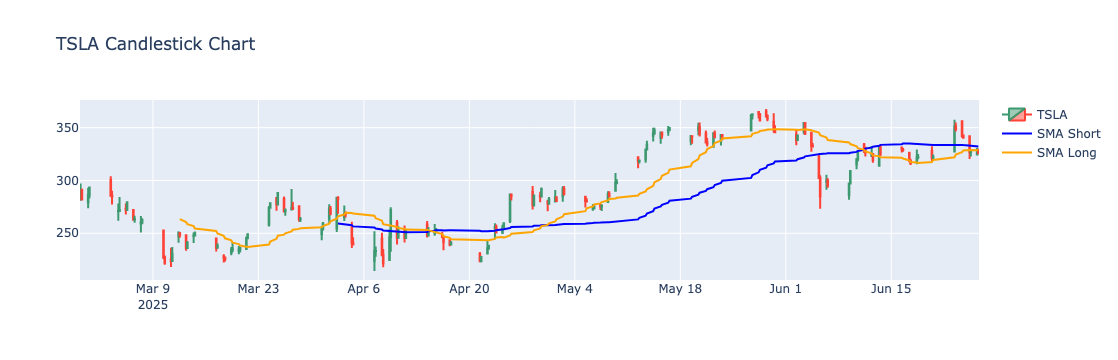

In [157]:
visualize_interactive(df)

In [158]:
df_with_signals = generate_ma_crossover_signals(df)

In [159]:
print("Buy Signals:")
print(df_with_signals[df_with_signals['Signal'] == 1][['Close', 'SMA_short', 'SMA_long']])
print("\nSell Signals:")
print(df_with_signals[df_with_signals['Signal'] == -1][['Close', 'SMA_short', 'SMA_long']])

Buy Signals:
                                Close   SMA_short    SMA_long
Datetime                                                     
2025-04-15 09:30:00-04:00  252.149902  252.451906  251.779990
2025-06-11 09:30:00-04:00  330.929993  329.142118  329.031271

Sell Signals:
                                Close   SMA_short    SMA_long
Datetime                                                     
2025-04-30 09:30:00-04:00  278.029999  257.719001  257.926344


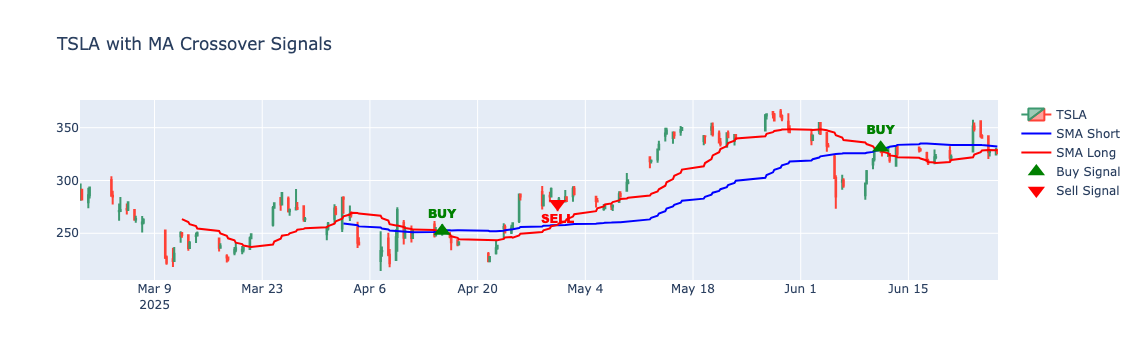

In [160]:
visualize_interactive_with_signals(df_with_signals)